# Classification

Data scientists are often tasked with automating decisions for business problems. Is an email an attempt at phishing? Is a customer likely to churn? Is the web user likely to click on an advertisement? 

These are all classification problems, a form of super‐ vised learning in which we first train a model on data where the outcome is known and then apply the model to data where the outcome is not known. Classification is perhaps the most important form of prediction: the goal is to predict whether a record is a 1 or a 0 (phishing/not-phishing, click/don’t click, churn/don’t churn), or in some cases, one of several categories (for example, Gmail’s filtering of your inbox into “primary,” “social,” “promotional,” or “forums”).

## Content
- **Naive Bayes**
    - Why Exact Bayesian Classification Is Impractical
    - The Naive Solution
    - Numeric Predictor Variables
- **Discriminant Analysis***
    - Covariance Matrix
    - Fisher's Linear Discriminant (A Simple Example)
- **Logistic Regression**
    - Logistic Response Function and Logit
    - Logistic Regression and the GLM 
    - Generalized Linear Models 
    - Predicted Values from Logistic Regression 
    - Interpreting the Coefficients and Odds Ratios 
    - Linear and Logistic Regression: Similarities and Differences  
    - Assessing the Model
- **Evaluating Classification Models**
    - Confusion Matrix 
    - The Rare Class Problem 
    - Precision, Recall, and Specificity 
    - ROC Curve 
    - AUC 
    - Lift
- **Strategies for Imbalanced Data**
    - Undersampling 
    - Oversampling and Up/Down Weighting 
    - Data Generation 233 Cost-Based Classification 
    - Exploring the Predictions 

## More Than Two Categories?

The vast majority of problems involve a binary response. Some classification prob‐ lems, however, involve a response with more than two possible outcomes. For exam‐ ple, at the anniversary of a customer’s subscription contract, there might be three outcomes: the customer leaves or “churns” (Y = 2), goes on a month-to-month con‐ tract (Y = 1), or signs a new long-term contract (Y = 0). The goal is to predict Y = j for j = 0, 1, or 2. Most of the classification methods in this chapter can be applied, either directly or with modest adaptations, to responses that have more than two outcomes. Even in the case of more than two outcomes, the problem can often be recast into a series of binary problems using conditional probabilities. For example, to predict the outcome of the contract, you can solve two binary prediction problems:

- Predict whether Y = 0 or Y > 0.
- Given that Y > 0, predict whether Y = 1 or Y = 2.

In this case, it makes sense to break up the problem into two cases: (1) whether the customer churns; and (2) if they don’t churn, what type of contract they will choose. From a model-fitting viewpoint, it is often advantageous to convert the multiclass problem to a series of binary problems. This is particularly true when one category is much more common than the other categories.

## Naive Bayes

Important key terms:
- **Conditional probability**
- **Posterior probability**(*in contrast to the prior probability*)

### Why Exact Bayesian Classification Is Impractical

When the number of predictor variables exceeds a handful, many of the records to be classified will be without exact matches. In the naive Bayes solution, we no longer restrict the probability calculation to those records that match the record to be classified. Instead, we use the entire data set. The naive Bayes modification is as follows:

1. For a binary response Y = i (i = 0 or 1), estimate the individual conditional prob‐ abilities for each predictor $P(X_j|Y=i)$; these are the probabilities that the pre‐ dictor value is in the record when we observe Y = i. This probability is estimated by the proportion of Xj values among the Y = i records in the training set.
2. Multiply these probabilities by each other, and then by the proportion of records belonging to Y = i.
3. Repeat steps 1 and 2 for all the classes.
4. Estimate a probability for outcome i by taking the value calculated in step 2 for
class i and dividing it by the sum of such values for all classes.
5. Assign the record to the class with the highest probability for this set of predictor
values.

In other words:
The probability of observing outcome Y=i, given a set of predictor values $X_1,...,X_p$

$$
P(Y=i|X_1,...,X_p)
$$

Using Bayes Theorem, the Law of Total Probability, and the naive Bayes assumption of conditional independence we get:

$$
P(Y=i|X_1,...,X_p) = \frac{P(Y=i)\Pi_{j=1}^p P(X_j|Y=i)}{P(Y=0)\Pi_{j=1}^p P(X_j|Y=0)+P(Y=1)\Pi_{j=1}^p P(X_j|Y=1)}
$$

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'

In [4]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X, y)


MultinomialNB(alpha=1e-10, fit_prior=False)

The model can be used to predict the outcome of a new loan. We use the last value of the data set for testing:

In [5]:
new_loan = X.loc[146:146, :]

print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653699  0.346301


The prediction also returns a posterior estimate of the probability of default. The naive Bayesian classifier is known to produce biased estimates. However, where the goal is to rank records according to the probability that Y = 1, unbiased estimates of probability are not needed, and naive Bayes produces good results.

### Numeric Predictor Variables

To apply naive Bayes to numerical predictors, one of two approaches must be taken:

- Bin and convert the numerical predictors to categorical predictors and apply the algorithm of the previous section.
- Use a probability model—for example, the normal distribution —to estimate the conditional probability $P(X_j| Y = i)$.

## Discriminant Analysis

Important key terms:
- **Covariance**
- **Discriminant function**
- **Discriminant weights**

### Covariance Matrix

To understand discriminant analysis, it is first necessary to introduce the concept of covariance between two or more variables. The covariance measures the relationship between two variables x and z. Denote the mean for each variable by $\bar{x}$ and $\bar{z}$. The covariance $s_{x, z}$ between x and z is given by:

$$
s_{x, z} = \frac{\sum_{i=1}^n (x_i-\bar{x})(z_i-\bar{z})}{n-1}
$$

where n is the number of records.

Positive values indicate a positive relationship and negative values indicate a negative relationship. Covariance scale depends on the scale of the variables x and z. The covariance matrix $\sum$ for x and z consists of the individual variable variances, $s_x^2$ and $s_z^2$, on the diagonal (where row and column are the same variable) and the covariances between variable pairs on the off-diagonals:

$$
\sum =
\begin{bmatrix}
s_x^2& s_{x, z}\\
s_{z, x}& s_z^2
\end{bmatrix}
$$

### Fisher's Linear Discriminant (A Simple Example)



In [6]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


### Using Discriminant Analysis for Feature Selection
If the predictor variables are normalized prior to running LDA, the discriminator weights are measures of variable importance, thus providing a computationally efficient method of feature selection.

In [7]:
# The lda function can predict the probability of “default” versus “paid off ”:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())


    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


A plot of the predictions helps illustrate how LDA works. Using the output from the
predict function, a plot of the estimated probability of default is produced as follows:

In [8]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio,default
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135,0.553544
1,16982,default,credit_card,15.49,0.40,5.43165,0.558953
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003,0.272696
3,34580,paid off,major_purchase,21.11,0.40,2.33482,0.506254
4,14424,default,debt_consolidation,16.46,0.45,12.10320,0.609952


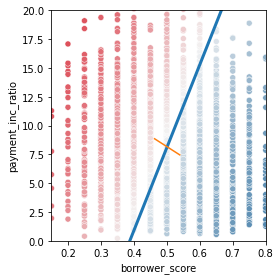

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

Using the discriminant function weights, LDA splits the predictor space into two regions, as shown by the solid line. The predictions farther away from the line in both directions have a higher level of confidence (i.e., a probability further away from 0.5).

## Logistic Regression

Important key terms:
- **Logit**
- **Odds**
- **Log odds**

### Logistic Response Function and Logit

The key ingredients for logistic regression are the logistic response function and the logit, in which we map a probability (which is on a 0–1 scale) to a more expansive scale suitable for linear modeling.

### Logistic Regression and the GLM

The response in the logistic regression formula is the log odds of a binary outcome of 1. We observe only the binary outcome, not the log odds, so special statistical methods are needed to fit the equation. Logistic regression is a special instance of a generalized linear model (GLM) developed to extend linear regression to other settings.

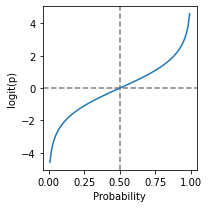

In [10]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

In [11]:

predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True, dtype=int)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6380884395576985
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


In [12]:
# Note that the intercept and coefficients are reversed compared to the R model.
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


In [13]:
# This reverses the order of the predicted classes and as a consequence, the coefficients will be reversed.

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, 
             index=X.columns)

intercept  1.638088492616834
classes [0. 1.]


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


### Generalized Linear Models

Generalized linear models (GLMs) are characterized by two main components:
- A probability distribution or family (binomial in the case of logistic regression)
- A link function—i.e., a transformation function that maps the response to the
predictors (logit in the case of logistic regression)

Logistic regression is by far the most common form of GLM. A data scientist will
encounter other types of GLMs. Sometimes a log link function is used instead of the
logit; in practice, use of a log link is unlikely to lead to very different results for most
applications. The Poisson distribution is commonly used to model count data (e.g.,
the number of times a user visits a web page in a certain amount of time). Other fam‐
ilies include negative binomial and gamma, often used to model elapsed time (e.g.,
time to failure). In contrast to logistic regression, application of GLMs with these
models is more nuanced and involves greater care. These are best avoided unless you
are familiar with and understand the utility and pitfalls of these methods.

### Predicted Values from Logistic Regression

The predicted value from logistic regression is in terms of the log odds:
$\hat{Y} = \log (Odds(Y = 1)) $. The predicted probability is given by the logistic response
function:

$$
\hat{p} = \frac{1}{1+e^{-\hat{Y}}}
$$

In [16]:

pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757850     -0.760423
std        0.378032      0.390419
min       -2.768873     -3.538864
25%       -0.985728     -0.977164
50%       -0.697366     -0.688946
75%       -0.472209     -0.467076
max       -0.029476     -0.064787


In [17]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500001      0.499999
std        0.167336      0.167336
min        0.062733      0.029046
25%        0.373167      0.376377
50%        0.497895      0.502105
75%        0.623623      0.626833
max        0.970954      0.937267


### Interpreting the Coefficients and Odds Ratios

One advantage of logistic regression is that it produces a model that can be scored to
new data rapidly, without recomputation. Another is the relative ease of interpreta‐
tion of the model, as compared with other classification methods. The key conceptual
idea is understanding an odds ratio. The odds ratio is easiest to understand for a
binary factor variable X:

$$
\text{odds ratio} = \frac{Odds(Y=1|X=1)}{Odds(Y=1|X=0)}
$$

This is interpreted as the odds that Y = 1 when X = 1 versus the odds that Y = 1 when
X = 0. If the odds ratio is 2, then the odds that Y = 1 are two times higher when X = 1
versus when X = 0.

Why bother with an odds ratio rather than probabilities? We work with odds because
the coefficient $\beta_j$ in the logistic regression is the log of the odds ratio for $X_j$.

An example will make this more explicit. The regression coefficient for `purpose_small_business` is
1.21526. This means that a loan to a small business compared to a loan to pay off
credit card debt reduces the odds of defaulting versus being paid off by
$e^1.21526 \approx 3.4$. Clearly, loans for the purpose of creating or expanding a small
business are considerably riskier than other types of loans.

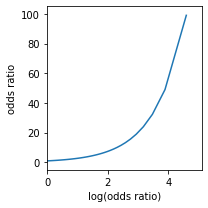

In [18]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

Odds ratios for numeric variables X can be interpreted similarly: they measure the
change in the odds ratio for a unit change in X. 

For example, the effect of increasing the payment-to-income ratio from, say, 5 to 6 increases the odds of the loan defaulting by a factor of $exp(0.08244) \approx 1.09$. The variable `borrower_score` is a score on the borrowers’ creditworthiness and ranges from 0 (low) to 1 (high). The odds of the best
borrowers relative to the worst borrowers defaulting on their loans is smaller by a
factor of $exp(− 4.61264) \approx 0.01$. 

In other words, the default risk from the borrowers with the poorest creditworthiness is 100 times greater than that of the best borrowers!

### Linear and Logistic Regression: Similarities and Differences

Linear regression and logistic regression share many commonalities. Both assume a
parametric linear form relating the predictors with the response. Exploring and find‐
ing the best model are done in very similar ways. Extensions to the linear model, like
the use of a spline transform of a predictor, are equally
applicable in the logistic regression setting. Logistic regression differs in two funda‐
mental ways:

- The way the model is fit (least squares is not applicable)
- The nature and analysis of the residuals from the model

#### Fitting the model

The model must be fit using maximum likelihood
estimation (MLE). Maximum likelihood estimation is a process that tries to find the
model that is most likely to have produced the data we see. 

### Maximum Likelihood Estimation

Here is a bit more detail, if you like statistical symbols: start with a set of data $(X_1, X_2,...,X_n)$ and a probability model $P_\theta (X_1, X_2,...,X_n)$ that depends on a set of
parameters $\theta$.  The goal of MLE is to find the set of parameters $\hat{\theta}$ that maximizes the value of $P_\theta (X_1, X_2,...,X_n)$; that is, it maximizes the probability of observing $(X_1, X_2,...,X_n)$ given the model P. In the fitting process, the model is evaluated using
a metric called deviance:

$$
\text{deviance} = -2\log \left(P_\theta (X_1, X_2,...,X_n) \right)
$$

Lower deviance corresponds to a better fit.

### Assessing the Model

Like other classification methods, logistic regression is assessed by how accurately the
model classifies new data. As
with linear regression, some additional standard statistical tools are available to
examine and improve the model. Along with the estimated coefficients, R reports the
standard error of the coefficients (SE), a z-value, and a p-value:

In [20]:
# use GLM (general linear model) with the binomial family to 
# fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Thu, 29 Aug 2024   Deviance:                       57515.
Time:                        21:26:40   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

Interpretation of the p-value comes with the same caveat as in regression and should
be viewed more as a relative indicator of variable importance than as a formal measure of statistical significance. A logistic regression model, which has a binary response, does not have an associated RMSE or R-squared. Instead, a logistic regression model is typically evaluated using more general metrics for classification; Many other concepts for linear regression carry over to the logistic regression setting (and other GLMs). For example, you can use stepwise regression, fit interaction
terms, or include spline terms. The same concerns regarding confounding and correlated variables apply to logistic regression

In [21]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Thu, 29 Aug 2024   Deviance:                       57462.
Time:                                               21:30:53   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                      

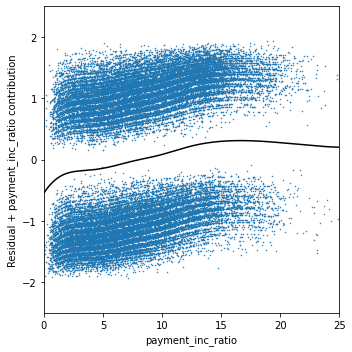

In [22]:
# Analysis of residuals
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

## Evaluating Classication Models

It is common in predictive modeling to train a number of different models, apply each to a holdout sample, and assess their performance. Sometimes, after a number of models have been evaluated and tuned, and if there are enough data, a third holdout sample, not used previously, is used to estimate how the chosen model will perform with completely new data. Different disciplines and practitioners will also use the terms validation and test to refer to the holdout sample(s). Fundamentally, the assessment process attempts to learn which model produces the most accurate and useful predictions.

Important key terms:
- **Accuracy**
- **Confusion matrix**
- **Sensitivity**
- **Specificity**
- **Precision**
- **ROC curve**
- **Lift**

### Confusion Matrix

In [23]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


In [24]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14336  8335]
 [ 8148 14523]]
